In [9]:
%cd "/content/drive/My Drive/Uni Stuff/DSinLS/Task7"

/content/drive/My Drive/Uni Stuff/DSinLS/Task7


In [10]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

In [0]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

In [0]:
def deriv(y, t, N, beta, gamma, delta, alpha_opt, rho):
    S, E, I, R, D = y
    def alpha(t):
        return s * I/N + alpha_opt

    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
    dRdt = (1 - alpha(t)) * gamma * I
    dDdt = alpha(t) * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

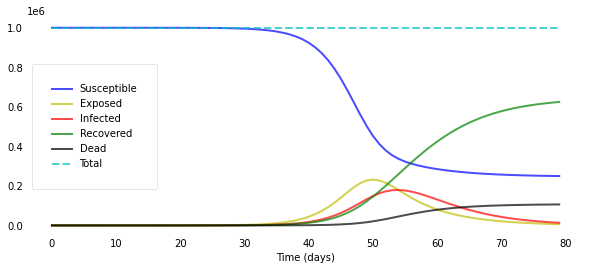

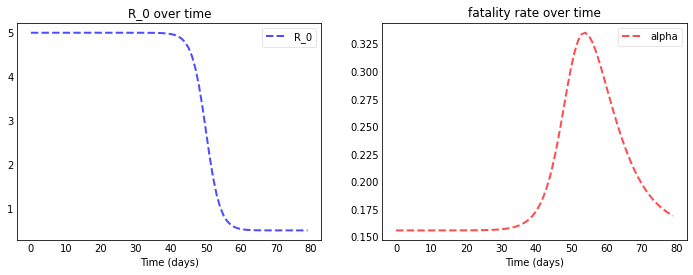

In [13]:
def Model(N,D,gamma,delta, R_0_start, k, x0, R_0_end):

    def logistic_R_0(t):
        return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

    def beta(t):
        return logistic_R_0(t) * gamma

    alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
    proportion_of_agegroup = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}
    alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

    rho = 1/9  # 9 days from infection until death
    S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed


    t = np.linspace(0, 79, 80) # Grid of time points (in days)
    y0 = S0, E0, I0, R0, D0 # Initial conditions vector

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha_opt, rho))
    S, E, I, R, D = ret.T
    R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
    Alpha_over_time = [s * I[i]/N + alpha_opt for i in range(len(t))]  # to plot alpha over time
    return t, S, E, I, R, D, R0_over_time, Alpha_over_time


N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
s = 1.0
R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5
t, S, E, I, R, D, R0_over_time, Alpha_over_time=Model(N,D,gamma,delta,R_0_start, k, x0, R_0_end )
plotseird(t, S, E, I, R, D, R0=R0_over_time, Alpha=Alpha_over_time)

In [0]:
df = pd.read_csv('./Data/ABM_data.csv',delimiter=';')
#x_data=df.day.to_list()
y_data=df.confirmed_cases.to_list()
x_data = np.linspace(0, 79, 80, dtype=int) 

In [0]:
params_init_min_max = {"R_0_start": (3.0, 1.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5)} 

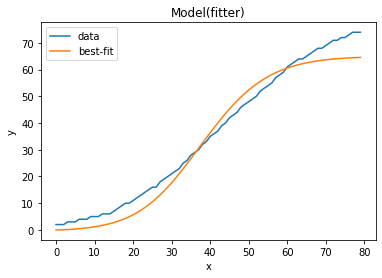

In [20]:
N = 80
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
s = 1.0

def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(N,D,gamma,delta,R_0_start, k, x0, R_0_end )
    return ret[4]

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

result = mod.fit(y_data, params, method="least_squares", x=x_data)
result.best_values
result.plot_fit(datafmt="-");

4.36253751865368


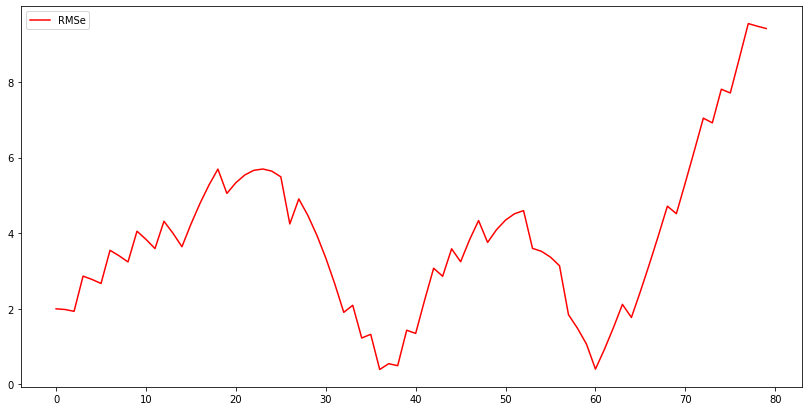

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse=[]
for actual_element , predict_element in zip(y_data, result.best_fit):
   rmse.append(sqrt(((predict_element - actual_element) ** 2).mean()))

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_value = sqrt(mean_squared_error(y_data, result.best_fit))

print(rmse_value)

plt.figure(figsize=(14, 7))
plt.plot(x_data, rmse, color="red", label="RMSe")
plt.legend()

